In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns=50

In [2]:
train = pd.read_csv('train.csv',index_col='Id')
test = pd.read_csv('test.csv',index_col='Id')

In [3]:
print(train.columns.difference(test.columns))
print(test.columns.difference(train.columns))
#確定除了label SalePrice之外訓練和測試資料的欄位是一樣的

Index(['SalePrice'], dtype='object')
Index([], dtype='object')


In [4]:
#取得訓練資料的房價
price = train['SalePrice']
#合併訓練和測試資料
data = train.append(test)
#拿掉SalePrice，以免造成data leakage
data = data.drop('SalePrice',axis=1)
#因為針對類別變項，所以只選取object data ttype
data = data.select_dtypes('object')
#######################<>
#把所有類別變項欄位進行one-hot-encoding，dummy_na=False(na值不增加na欄位，而是全部填0，因為未來資料可能有新的Nan)，同時也比較能因應未來若有新資料的問題(某欄位有新的NAN)
data = pd.get_dummies(data)

In [5]:
#未來新資料輸入的欄位要按照這個順序，若有欄位不存在則fillna(0)，若有新的欄位則會被捨棄
print(data.columns)
print(data.columns.size)

Index(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_Pave',
       'LotShape_IR1',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=252)
252


In [6]:
import tensorflow as tf
import tensorflow_probability as tfp

In [7]:
def KLDivergence_NormalDistribution(mean,log_var):
    #原文的損失函數，計算某高斯分布(mean,log_variance)與標準高斯分布N(0,1)的KLdivergence
    #公式推導參考以上文章
    var = tf.math.exp(log_var)
    #各計算分量的KLDivergence
    loss = (-log_var + mean**2 + var - 1)/2
    #由於各分量獨立，最後再將KLDivergence總和起來就好
    loss = tf.math.reduce_sum(loss,axis=-1)
    #計算整個batch的平均loss
    loss = tf.math.reduce_mean(loss)
    return loss

def Resample_Distance(mean,log_var,sample):
    #參考:https://www.tensorflow.org/tutorials/generative/cvae
    #若sample由某個高斯分布取出(mean,log_variance)，且該分布要與標準高斯分布看齊，
    #換句話說該sample從該分布抽出的機率與從標準高斯分布的機率應該要相似(KLdivergence相近)
    def gaussian_log_prob(mean,log_var,sample):
        #計算某點從多變量且各變量獨立的高斯分布取樣的機率對數值，因為變量獨立，使用MultivariateNormalDiag
        var = tf.math.exp(log_var)
        std = tf.math.sqrt(var)
        log_prob = tfp.distributions.MultivariateNormalDiag(mean,std).log_prob(sample)
        return log_prob
    log_prob_from_dist = gaussian_log_prob(mean, log_var, sample)
    log_prob_from_norm = gaussian_log_prob(tf.zeros_like(mean), tf.zeros_like(mean), sample)
    #計算機率的差異
    loss = log_prob_from_dist - log_prob_from_norm
    #計算整個batch的平均loss
    loss = tf.math.reduce_mean(loss)
    return loss

In [8]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,body,latent_dim):
        super().__init__()
        self.body = body
        self.last_layer = tf.keras.layers.Dense(latent_dim*2)
    
    def call(self,x):
        x = self.body(x)
        #z_dist.shape (batch_size, latent_dim*2[z_mean, z_log_var])
        #latent space的mean和log_var同時預測，並且再拆開
        z_dist = self.last_layer(x)
        z_mean, z_log_var = tf.split(z_dist,2,axis=-1)
        return z_mean, z_log_var
    
    def predict(self,x):
        #預測只回傳分布中心位置
        z_mean, z_log_var = self(x)
        return z_mean
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self,body):
        super().__init__()
        self.body = body
        self.last_layer = tf.keras.layers.Dense(252,activation='sigmoid') #252是要重建的欄數
        
    def call(self,z):
        z = self.body(z)
        x_reconstruct = self.last_layer(z)
        return x_reconstruct
    
    
class Model(tf.keras.Model):
    def __init__(self,encoder_body,decoder_body,latent_dim,distribution_regularization_rate=0.002):
        super().__init__()
        self.encoder = Encoder(encoder_body,latent_dim)
        self.decoder = Decoder(decoder_body)
        self.distribution_regularization_rate = distribution_regularization_rate
        
    def call(self,x):
        x = tf.cast(x, tf.float64)
        #encoder將資料投影至latent space
        z_mean, z_log_var = self.encoder(x)
        #從latent space的分布中取樣
        z_resample = self.resample(z_mean, z_log_var)
        #利用取樣點重建輸入資料
        x_reconstruct = self.decoder(z_resample)
        return x_reconstruct, z_mean, z_log_var, z_resample
        
    def resample(self, z_mean, z_log_var):
        #z_mean.shape: (batch_size,latent_dim)
        #z_log_var.shape: (batch_size,latent_dim)
        #encoder將資料轉化為在latent space(較低維度空間)上的高斯分布，參數為分布中心(z_mean),變異數自然對數(z_log_var)，
        #且z_log_var需轉換成公式需要的標準差(z_std)
        z_var = tf.math.exp(z_log_var)
        z_std = tf.math.sqrt(z_var)
        z_resample = tfp.distributions.MultivariateNormalDiag(z_mean,z_std).sample()
        #在給定的高斯分布(z_mean,z_std)重新取樣，且取樣的過程可導
        #z_resample.shape: (batch_size,latent_dim)
        return z_resample
    
    def encode(self,x):
        return self.encoder(x)[0]
    
    def decode(self,z):
        return self.decoder(z)
        
    def compile(self,latent_loss,optimizer):
        super().compile()
        self.optimizer = optimizer
        
        self.latent_distribution_loss = latent_loss
        self.reconstruction_loss = tf.keras.losses.BinaryCrossentropy()
        
        self.latent_distribution_loss_metric = tf.keras.metrics.Mean(name='latent_dist')
        self.reconstruction_loss_metric = tf.keras.metrics.Mean(name='reconstruct')
        self.total_loss_metric = tf.keras.metrics.Mean(name='total')
    
    @property
    def metrics(self):
        return [self.latent_distribution_loss_metric,
                self.reconstruction_loss_metric,
                self.total_loss_metric]
    
    def compute_loss(self, x, x_reconstruct, z_mean, z_log_var, z_resample):
        if self.latent_distribution_loss is KLDivergence_NormalDistribution:
            latent_distribution_loss = self.latent_distribution_loss(z_mean,z_log_var)
        else:
            latent_distribution_loss = self.latent_distribution_loss(z_mean,z_log_var,z_resample)
        
        reconstruction_loss = self.reconstruction_loss(x, x_reconstruct)
        return latent_distribution_loss, reconstruction_loss
    
    def train_step(self,x):
        with tf.GradientTape() as tape:
            x_reconstruct, z_mean, z_log_var, z_resample = self(x)
            latent_distribution_loss, reconstruction_loss  = self.compute_loss(x, x_reconstruct, z_mean, z_log_var, z_resample)
            total_loss = self.distribution_regularization_rate * latent_distribution_loss + reconstruction_loss
            
        self.latent_distribution_loss_metric.update_state(latent_distribution_loss)
        self.reconstruction_loss_metric.update_state(reconstruction_loss)
        self.total_loss_metric.update_state(total_loss)
        
        gradients = tape.gradient(total_loss,self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {m.name:m.result() for m in self.metrics}
    
    def test_step(self,x):
        x_reconstruct, z_mean, z_log_var, z_resample = self(x)
        latent_distribution_loss, reconstruction_loss  = self.compute_loss(x, x_reconstruct, z_mean, z_log_var, z_resample)
        total_loss = self.distribution_regularization_rate * latent_distribution_loss + reconstruction_loss
            
        self.latent_distribution_loss_metric.update_state(latent_distribution_loss)
        self.reconstruction_loss_metric.update_state(reconstruction_loss)
        self.total_loss_metric.update_state(total_loss)
        
        return {m.name:m.result() for m in self.metrics}
    

In [13]:
def run(merge, distribution_regularization_rate, distribution_loss,  epochs_each_time=10, run_times=10 , seed=101):
    tf.random.set_seed(seed)
    encoder = tf.keras.Sequential([tf.keras.layers.Dense(200,activation='relu'),
                               tf.keras.layers.Dense(100,activation='relu'),
                               tf.keras.layers.Dense(50,activation='relu'),
                               tf.keras.layers.Dense(20,activation='relu')])
    decoder = tf.keras.Sequential([tf.keras.layers.Dense(20,activation='relu'),
                               tf.keras.layers.Dense(50,activation='relu'),
                               tf.keras.layers.Dense(100,activation='relu'),
                               tf.keras.layers.Dense(200,activation='relu')])
    model = Model(encoder,decoder,2,distribution_regularization_rate)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(distribution_loss,optimizer)
    
    if merge:
        print('''use both train data and test data to train VAE,
and project train data onto encoding space and draw scatter plot with the dot color painted according to the SalePrice column in train data ''')
        merge_ds = tf.data.Dataset.from_tensor_slices(data).shuffle(1000).batch(32)
        for i in range(run_times):
            model.fit(merge_ds,epochs=epochs_each_time)
            z = model.encode(data.loc[train.index].values)
            plot = plt.scatter(x = z[:,0],y=z[:,1],c=np.log(price.values),cmap='rainbow',s=2)
            plt.title(f'Projection of Encoding Space\nrun times: {i+1} ({epochs_each_time} epochs each time)')
            plt.colorbar(plot, label='log(SalePrice)')
            plt.show()
    else:
        print('split train and val data to verify whether data can be compressed and then reconstructed by VAE')
        train_ds = tf.data.Dataset.from_tensor_slices(data[:1460]).shuffle(1000).batch(32)
        val_ds = tf.data.Dataset.from_tensor_slices(data[1460:]).batch(32)
        model.fit(x=train_ds,validation_data=val_ds,epochs=epochs_each_time)
        

In [10]:
run(False, 0.003, KLDivergence_NormalDistribution)

split train and val data to verify whether data can be compressed and then reconstructed by VAE
Epoch 1/10
46/46 [==============================] - 3s 19ms/step - latent_dist: 6.7892 - reconstruct: 0.3396 - total: 0.3600 - val_latent_dist: 2.1037 - val_reconstruct: 0.2025 - val_total: 0.2089
Epoch 2/10
46/46 [==============================] - 0s 7ms/step - latent_dist: 2.2667 - reconstruct: 0.1972 - total: 0.2040 - val_latent_dist: 2.0578 - val_reconstruct: 0.1964 - val_total: 0.2026
Epoch 3/10
46/46 [==============================] - 0s 7ms/step - latent_dist: 1.9511 - reconstruct: 0.1950 - total: 0.2008 - val_latent_dist: 1.9939 - val_reconstruct: 0.1955 - val_total: 0.2015
Epoch 4/10
46/46 [==============================] - 0s 7ms/step - latent_dist: 1.7434 - reconstruct: 0.1942 - total: 0.1995 - val_latent_dist: 1.7169 - val_reconstruct: 0.1948 - val_total: 0.2000
Epoch 5/10
46/46 [==============================] - 0s 7ms/step - latent_dist: 1.6656 - reconstruct: 0.1930 - total: 0.

In [11]:
run(False, 0.003, Resample_Distance)

split train and val data to verify whether data can be compressed and then reconstructed by VAE
Epoch 1/10
46/46 [==============================] - 4s 25ms/step - latent_dist: 7.5302 - reconstruct: 0.3373 - total: 0.3599 - val_latent_dist: 1.9317 - val_reconstruct: 0.2020 - val_total: 0.2078
Epoch 2/10
46/46 [==============================] - 0s 7ms/step - latent_dist: 2.1200 - reconstruct: 0.1972 - total: 0.2036 - val_latent_dist: 1.9748 - val_reconstruct: 0.1965 - val_total: 0.2024
Epoch 3/10
46/46 [==============================] - 0s 6ms/step - latent_dist: 1.9261 - reconstruct: 0.1952 - total: 0.2009 - val_latent_dist: 1.9872 - val_reconstruct: 0.1959 - val_total: 0.2018
Epoch 4/10
46/46 [==============================] - 0s 6ms/step - latent_dist: 1.6754 - reconstruct: 0.1944 - total: 0.1994 - val_latent_dist: 1.6090 - val_reconstruct: 0.1953 - val_total: 0.2002
Epoch 5/10
46/46 [==============================] - 0s 6ms/step - latent_dist: 1.5773 - reconstruct: 0.1935 - total: 0.

use both train data and test data to train VAE,
and project train data onto encoding space and draw scatter plot with the dot color painted according to the SalePrice column in train data 
Epoch 1/3
92/92 [==============================] - 2s 4ms/step - latent_dist: 3.0855 - reconstruct: 0.2719 - total: 0.2874
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.3353 - reconstruct: 0.1968 - total: 0.2035
Epoch 3/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 0.7907 - reconstruct: 0.1896 - total: 0.1935


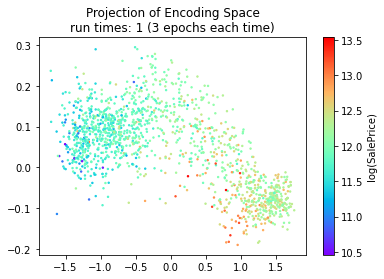

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.2254 - reconstruct: 0.1708 - total: 0.1769
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.4321 - reconstruct: 0.1662 - total: 0.1734
Epoch 3/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.5384 - reconstruct: 0.1619 - total: 0.1696


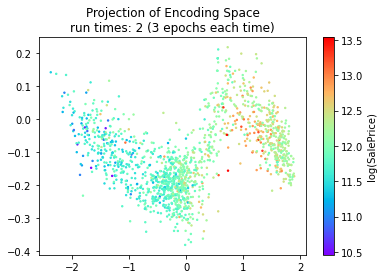

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.5836 - reconstruct: 0.1607 - total: 0.1686
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.5745 - reconstruct: 0.1599 - total: 0.1678
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.6274 - reconstruct: 0.1594 - total: 0.1676


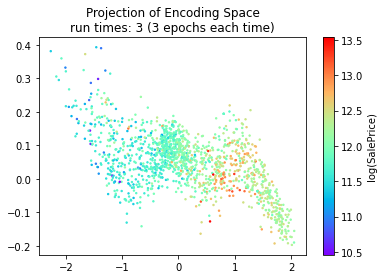

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.6443 - reconstruct: 0.1593 - total: 0.1675
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.6299 - reconstruct: 0.1586 - total: 0.1668
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.6721 - reconstruct: 0.1581 - total: 0.1665


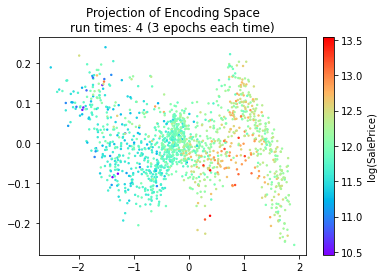

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.6850 - reconstruct: 0.1578 - total: 0.1663
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.7072 - reconstruct: 0.1577 - total: 0.1662
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.7252 - reconstruct: 0.1570 - total: 0.1656


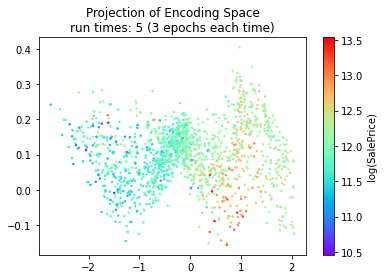

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.7363 - reconstruct: 0.1569 - total: 0.1655
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.7715 - reconstruct: 0.1566 - total: 0.1655
Epoch 3/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.7466 - reconstruct: 0.1566 - total: 0.1654


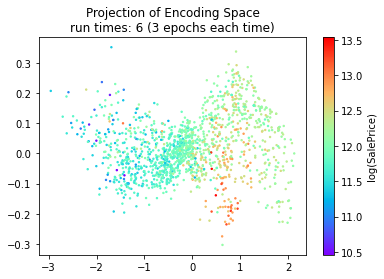

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.7685 - reconstruct: 0.1563 - total: 0.1652
Epoch 2/3
92/92 [==============================] - 0s 3ms/step - latent_dist: 1.7944 - reconstruct: 0.1559 - total: 0.1649
Epoch 3/3
92/92 [==============================] - 0s 3ms/step - latent_dist: 1.8214 - reconstruct: 0.1555 - total: 0.1646


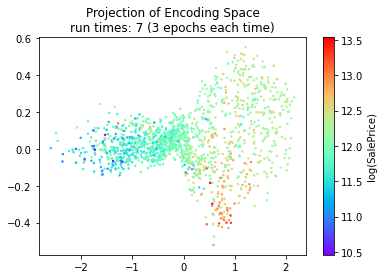

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.8497 - reconstruct: 0.1554 - total: 0.1646
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.9816 - reconstruct: 0.1541 - total: 0.1640
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.1640 - reconstruct: 0.1517 - total: 0.1625


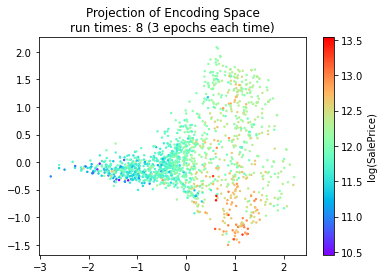

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.2281 - reconstruct: 0.1507 - total: 0.1619
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.2718 - reconstruct: 0.1497 - total: 0.1610
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.3328 - reconstruct: 0.1491 - total: 0.1608


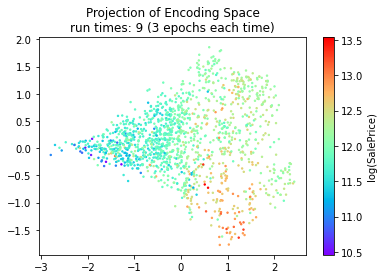

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.3250 - reconstruct: 0.1490 - total: 0.1606
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.3678 - reconstruct: 0.1480 - total: 0.1598
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.4372 - reconstruct: 0.1474 - total: 0.1595


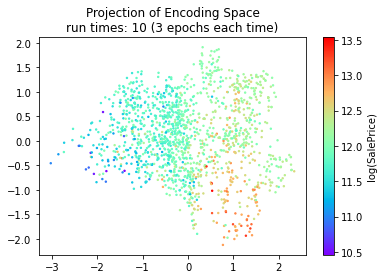

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.4985 - reconstruct: 0.1468 - total: 0.1593
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.5971 - reconstruct: 0.1456 - total: 0.1586
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.6414 - reconstruct: 0.1453 - total: 0.1585


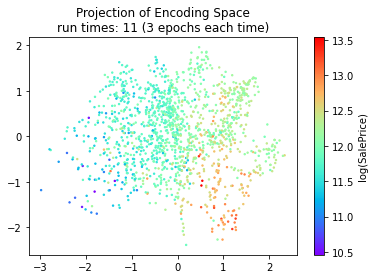

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.6587 - reconstruct: 0.1445 - total: 0.1578
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.6944 - reconstruct: 0.1443 - total: 0.1578
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.6628 - reconstruct: 0.1437 - total: 0.1571


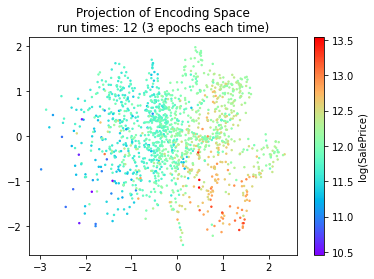

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.7635 - reconstruct: 0.1432 - total: 0.1570
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.7799 - reconstruct: 0.1425 - total: 0.1564
Epoch 3/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.8157 - reconstruct: 0.1428 - total: 0.1569


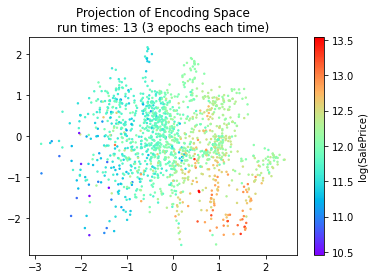

Epoch 1/3
92/92 [==============================] - 1s 6ms/step - latent_dist: 2.7770 - reconstruct: 0.1422 - total: 0.1560
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.8304 - reconstruct: 0.1421 - total: 0.1562
Epoch 3/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.8371 - reconstruct: 0.1414 - total: 0.1556


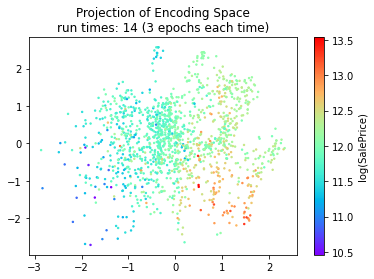

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.8944 - reconstruct: 0.1413 - total: 0.1558
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.9339 - reconstruct: 0.1406 - total: 0.1553
Epoch 3/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.9227 - reconstruct: 0.1405 - total: 0.1551


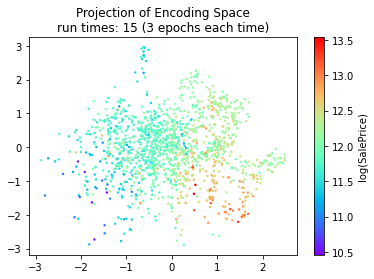

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.9899 - reconstruct: 0.1397 - total: 0.1546
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.0106 - reconstruct: 0.1393 - total: 0.1544
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.0501 - reconstruct: 0.1394 - total: 0.1546


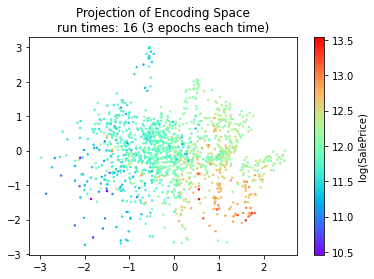

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 3.0415 - reconstruct: 0.1389 - total: 0.1541
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.0472 - reconstruct: 0.1386 - total: 0.1539
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.0957 - reconstruct: 0.1381 - total: 0.1535


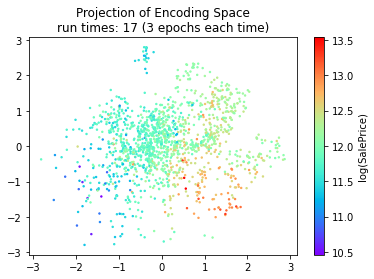

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.1023 - reconstruct: 0.1383 - total: 0.1538
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.1485 - reconstruct: 0.1374 - total: 0.1531
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.1424 - reconstruct: 0.1370 - total: 0.1527


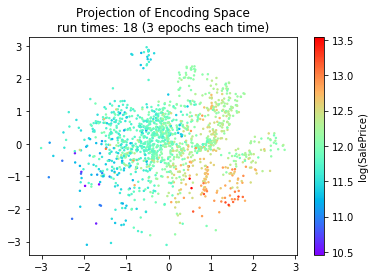

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.1677 - reconstruct: 0.1371 - total: 0.1529
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.2125 - reconstruct: 0.1365 - total: 0.1526
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.1976 - reconstruct: 0.1365 - total: 0.1525


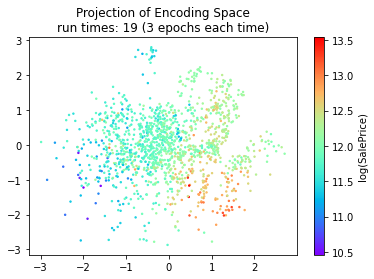

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.2528 - reconstruct: 0.1357 - total: 0.1520
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.2179 - reconstruct: 0.1359 - total: 0.1519
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.2265 - reconstruct: 0.1359 - total: 0.1520


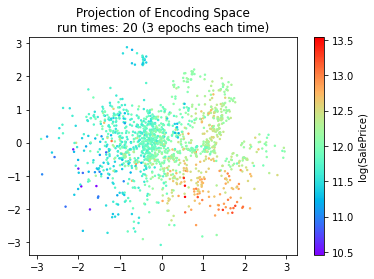

In [14]:
run(True, 0.005, KLDivergence_NormalDistribution, 3, 20)

use both train data and test data to train VAE,
and project train data onto encoding space and draw scatter plot with the dot color painted according to the SalePrice column in train data 
Epoch 1/3
92/92 [==============================] - 3s 5ms/step - latent_dist: 3.1861 - reconstruct: 0.2714 - total: 0.2873
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.1226 - reconstruct: 0.1970 - total: 0.2026
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 0.8273 - reconstruct: 0.1859 - total: 0.1900


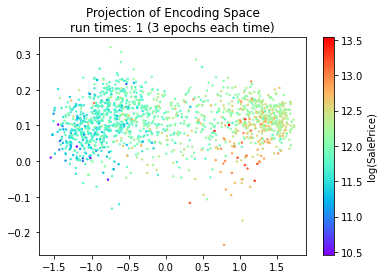

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.2027 - reconstruct: 0.1710 - total: 0.1770
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.3316 - reconstruct: 0.1682 - total: 0.1748
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.4609 - reconstruct: 0.1639 - total: 0.1712


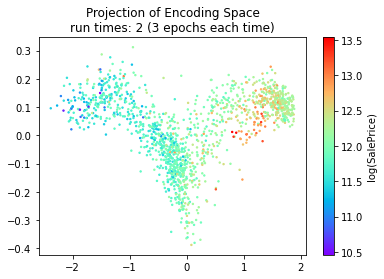

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.5358 - reconstruct: 0.1616 - total: 0.1693
Epoch 2/3
92/92 [==============================] - 0s 3ms/step - latent_dist: 1.5555 - reconstruct: 0.1606 - total: 0.1684
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.5910 - reconstruct: 0.1599 - total: 0.1678


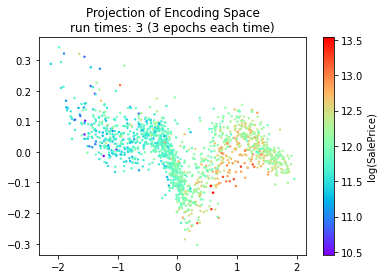

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.6148 - reconstruct: 0.1597 - total: 0.1677
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.6431 - reconstruct: 0.1588 - total: 0.1670
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.6622 - reconstruct: 0.1584 - total: 0.1667


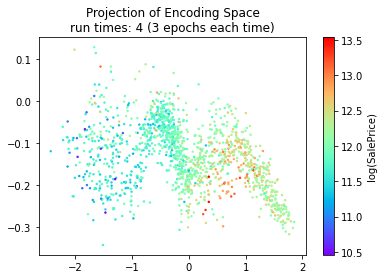

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.6970 - reconstruct: 0.1579 - total: 0.1664
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.6972 - reconstruct: 0.1578 - total: 0.1663
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.7126 - reconstruct: 0.1569 - total: 0.1655


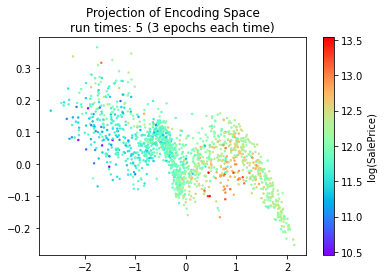

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.7434 - reconstruct: 0.1569 - total: 0.1656
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.7632 - reconstruct: 0.1565 - total: 0.1654
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.7583 - reconstruct: 0.1564 - total: 0.1652


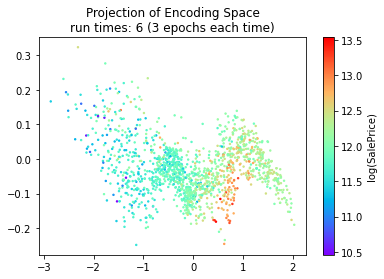

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.7846 - reconstruct: 0.1562 - total: 0.1652
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.8163 - reconstruct: 0.1558 - total: 0.1649
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.7995 - reconstruct: 0.1556 - total: 0.1646


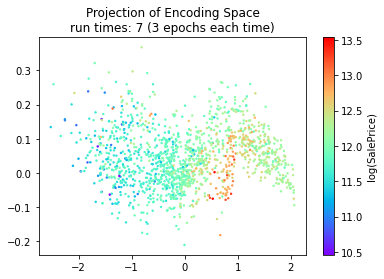

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.8128 - reconstruct: 0.1556 - total: 0.1647
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.8425 - reconstruct: 0.1553 - total: 0.1645
Epoch 3/3
92/92 [==============================] - 0s 3ms/step - latent_dist: 1.8622 - reconstruct: 0.1553 - total: 0.1646


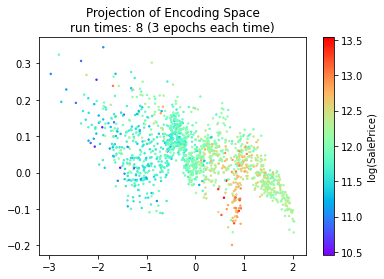

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.8397 - reconstruct: 0.1547 - total: 0.1639
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.8901 - reconstruct: 0.1544 - total: 0.1639: 0s - latent_dist: 1.9103 - reconstruct: 0.1539
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.8937 - reconstruct: 0.1541 - total: 0.1636


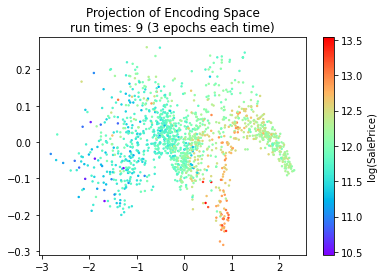

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.8760 - reconstruct: 0.1541 - total: 0.1635
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.9271 - reconstruct: 0.1538 - total: 0.1635
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.9175 - reconstruct: 0.1535 - total: 0.1631


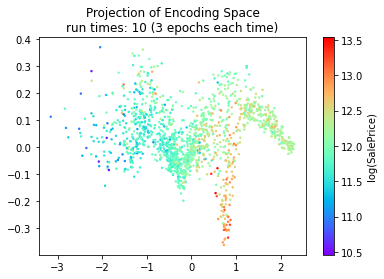

Epoch 1/3
92/92 [==============================] - 1s 6ms/step - latent_dist: 1.9441 - reconstruct: 0.1533 - total: 0.1630
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.9551 - reconstruct: 0.1531 - total: 0.1629
Epoch 3/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.9847 - reconstruct: 0.1527 - total: 0.1627


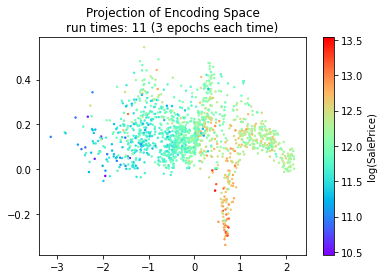

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 1.9854 - reconstruct: 0.1529 - total: 0.1629
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.0116 - reconstruct: 0.1524 - total: 0.1625
Epoch 3/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 1.9963 - reconstruct: 0.1523 - total: 0.1622


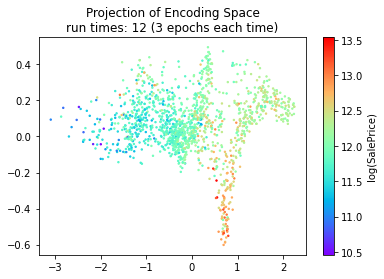

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.0476 - reconstruct: 0.1522 - total: 0.1625
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.0460 - reconstruct: 0.1514 - total: 0.1616
Epoch 3/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.0899 - reconstruct: 0.1512 - total: 0.1617


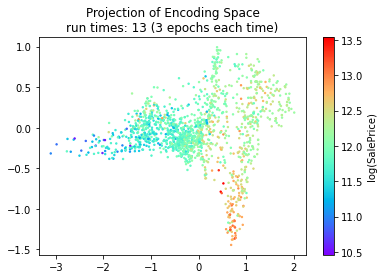

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.1420 - reconstruct: 0.1503 - total: 0.1611
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.2403 - reconstruct: 0.1493 - total: 0.1605
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.3222 - reconstruct: 0.1483 - total: 0.1599


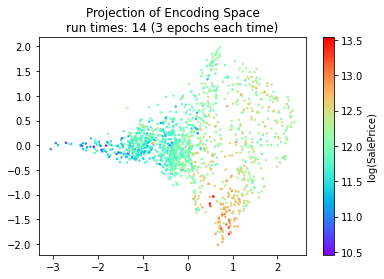

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.3446 - reconstruct: 0.1478 - total: 0.1595
Epoch 2/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.4319 - reconstruct: 0.1474 - total: 0.1596
Epoch 3/3
92/92 [==============================] - 0s 3ms/step - latent_dist: 2.4287 - reconstruct: 0.1471 - total: 0.1592


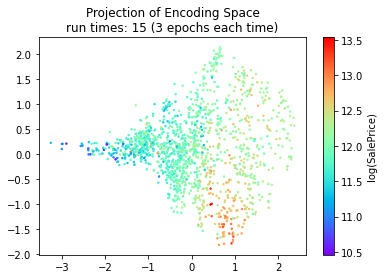

Epoch 1/3
92/92 [==============================] - 0s 5ms/step - latent_dist: 2.5000 - reconstruct: 0.1462 - total: 0.1587
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.5409 - reconstruct: 0.1452 - total: 0.1579
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.6160 - reconstruct: 0.1450 - total: 0.1581


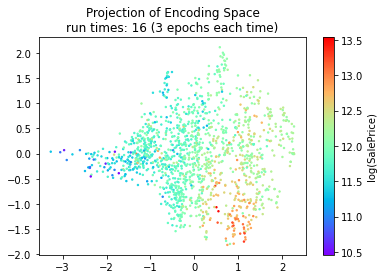

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.6816 - reconstruct: 0.1440 - total: 0.1574
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.7078 - reconstruct: 0.1440 - total: 0.1575
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.7546 - reconstruct: 0.1427 - total: 0.1565


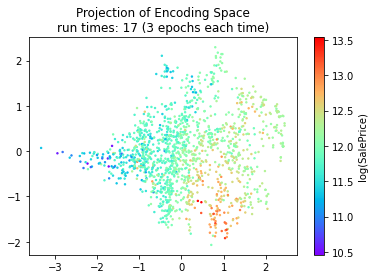

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.7767 - reconstruct: 0.1428 - total: 0.1567
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.8325 - reconstruct: 0.1416 - total: 0.1558
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.8756 - reconstruct: 0.1411 - total: 0.1554


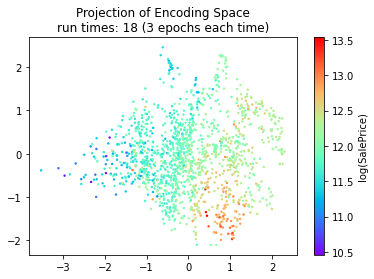

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.9034 - reconstruct: 0.1405 - total: 0.1550
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.9434 - reconstruct: 0.1403 - total: 0.1550
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 2.9935 - reconstruct: 0.1396 - total: 0.1545


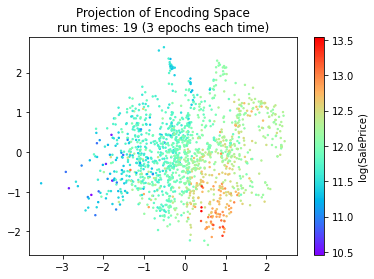

Epoch 1/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.0379 - reconstruct: 0.1390 - total: 0.1542
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.0014 - reconstruct: 0.1393 - total: 0.1543
Epoch 3/3
92/92 [==============================] - 0s 4ms/step - latent_dist: 3.0792 - reconstruct: 0.1385 - total: 0.1539


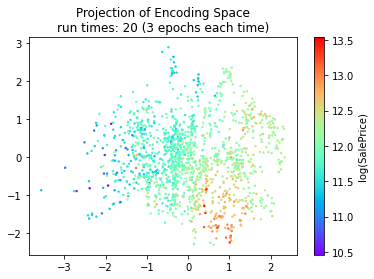

In [15]:
run(True, 0.005, Resample_Distance, 3, 20)